In [ ]:
#####################################################
###
### test an example from https://github.com/BiAPoL/Bio-image_Analysis_with_Python/blob/main/04_image_segmentation/12_Segmentation_3D.ipynb
###
#####################################################

In [1]:
from skimage.io import imread
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

import napari
from napari.utils import nbscreenshot

# For 3D processing, powerful graphics
# processing units might be necessary
cle.select_device('TX')

/Users/jingkui.wang/miniforge3/envs/image_env/lib/python3.9/site-packages/pyclesperanto_prototype/_tier0/_device.py:77: UserWarning: No OpenCL device found with TX in their name. Using Apple M1 Max instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


<Apple M1 Max on Platform: Apple (2 refs)>

In [2]:
input_image = imread("data/BMP4blastocystC3-cropped_resampled_8bit.tif")

voxel_size_x = 0.202
voxel_size_y = 0.202
voxel_size_z = 1

/Users/jingkui.wang/miniforge3/envs/image_env/lib/python3.9/site-packages/pyclesperanto_prototype/_tier9/_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


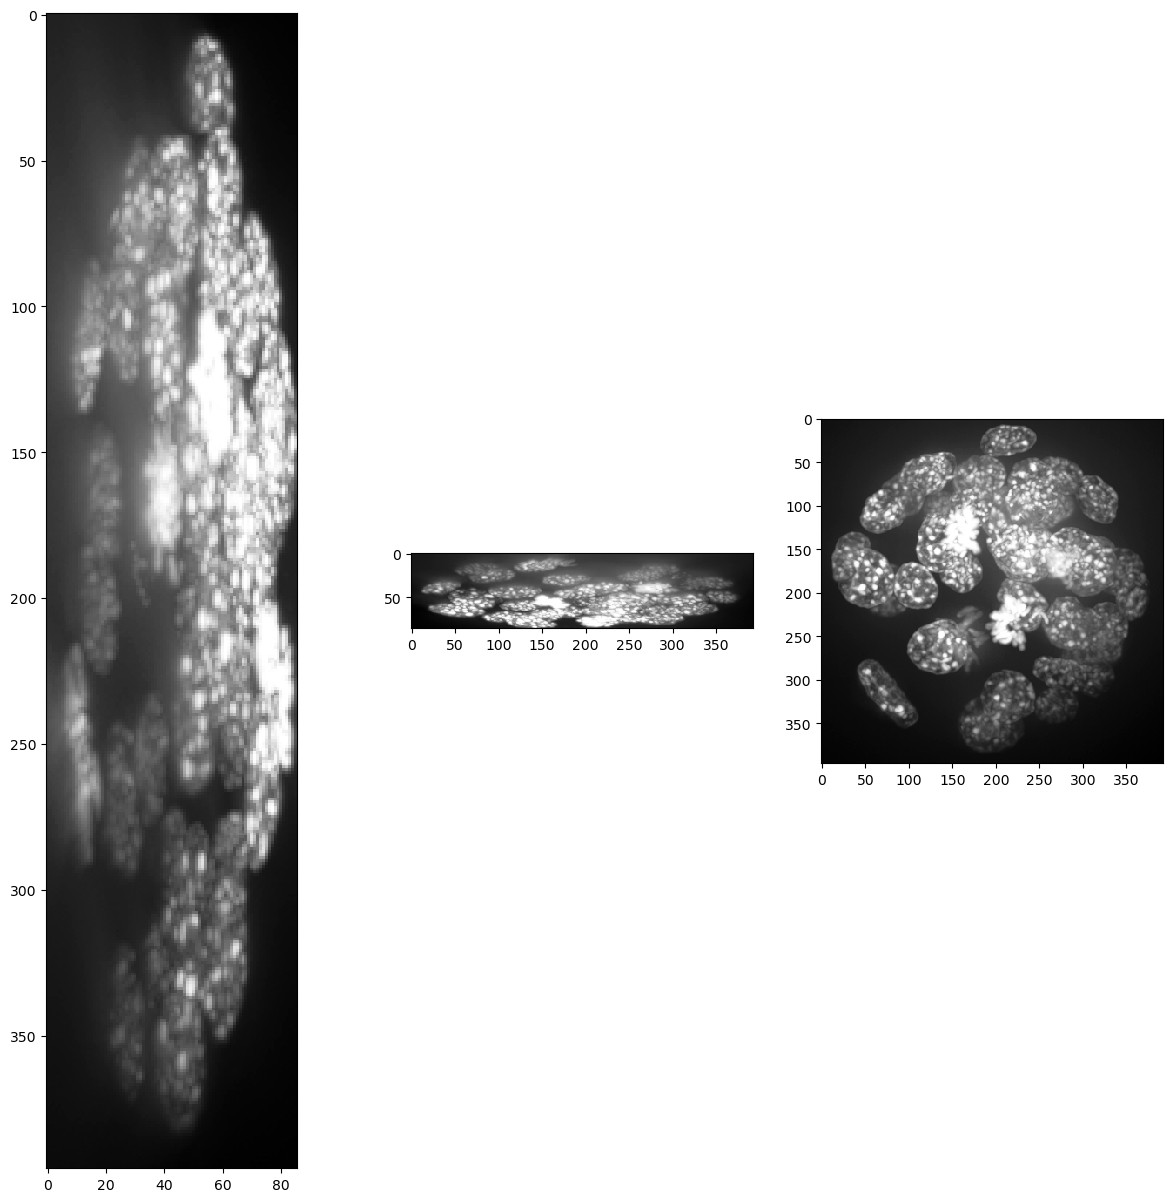

(86, 396, 393)


In [3]:
def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(projection_x, plot=axs[0], labels=labels)
    cle.imshow(projection_y, plot=axs[1], labels=labels)
    cle.imshow(projection_z, plot=axs[2], labels=labels)
    plt.show()

show(input_image)
print(input_image.shape)

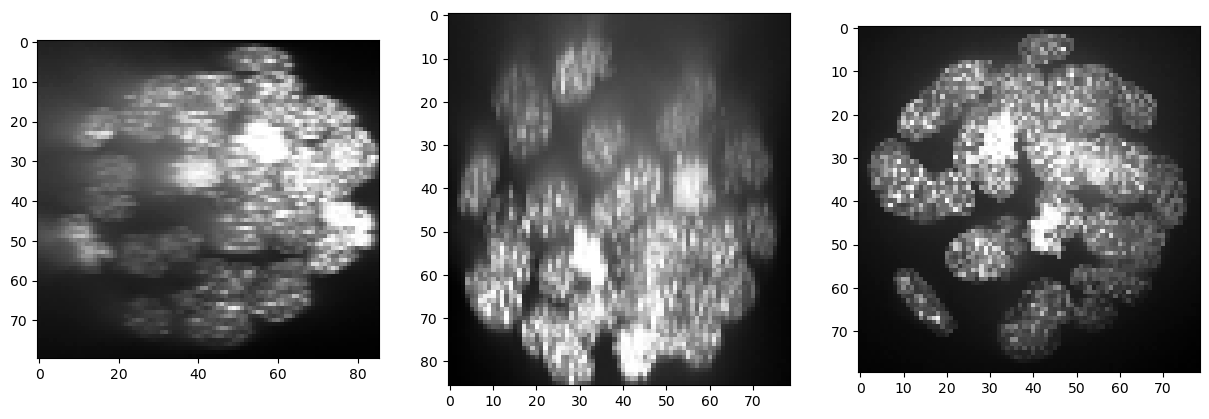

(86, 80, 79)


In [4]:
resampled = cle.scale(input_image, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, auto_size=True)

show(resampled)
print(resampled.shape)

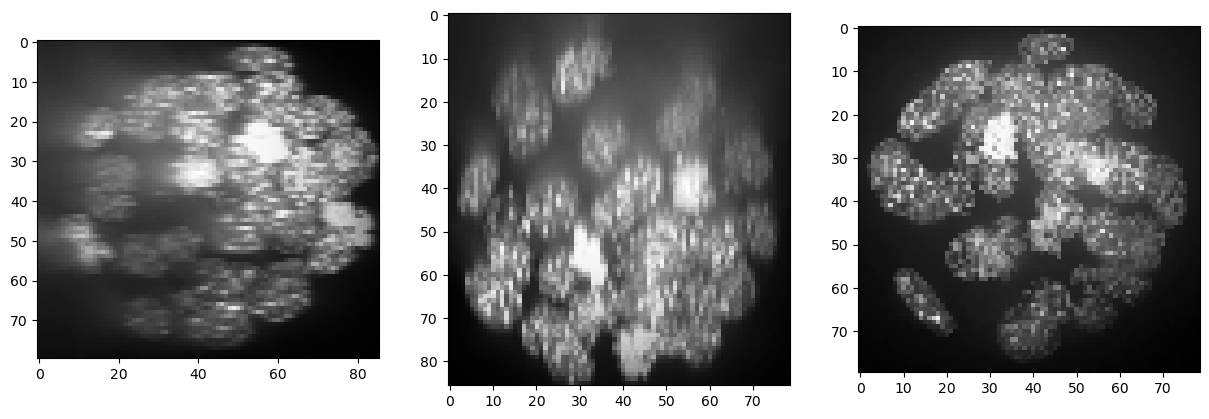

In [5]:
equalized_intensities_stack = cle.create_like(resampled)
a_slice = cle.create([resampled.shape[1], resampled.shape[0]])

num_slices = resampled.shape[0]
mean_intensity_stack = cle.mean_of_all_pixels(resampled)

corrected_slice = None
for z in range(0, num_slices):
    # get a single slice out of the stack
    cle.copy_slice(resampled, a_slice, z)
    # measure its intensity
    mean_intensity_slice = cle.mean_of_all_pixels(a_slice)
    # correct the intensity
    correction_factor = mean_intensity_slice/mean_intensity_stack
    corrected_slice = cle.multiply_image_and_scalar(a_slice, corrected_slice, correction_factor)
    # copy slice back in a stack
    cle.copy_slice(corrected_slice, equalized_intensities_stack, z)

show(equalized_intensities_stack)

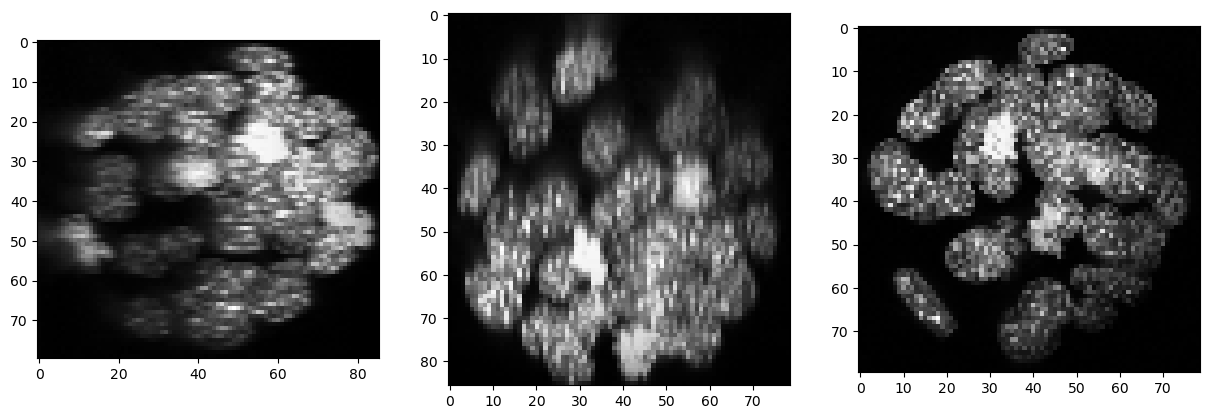

In [6]:
backgrund_subtracted = cle.top_hat_box(equalized_intensities_stack, radius_x=5, radius_y=5, radius_z=5)
show(backgrund_subtracted)

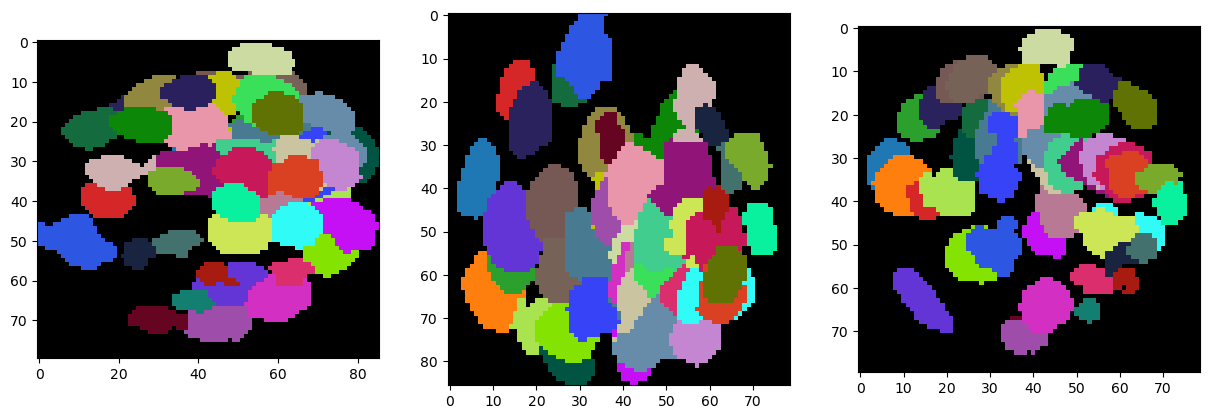

In [7]:
segmented = cle.voronoi_otsu_labeling(backgrund_subtracted, spot_sigma=3, outline_sigma=1)
show(segmented, labels=True)

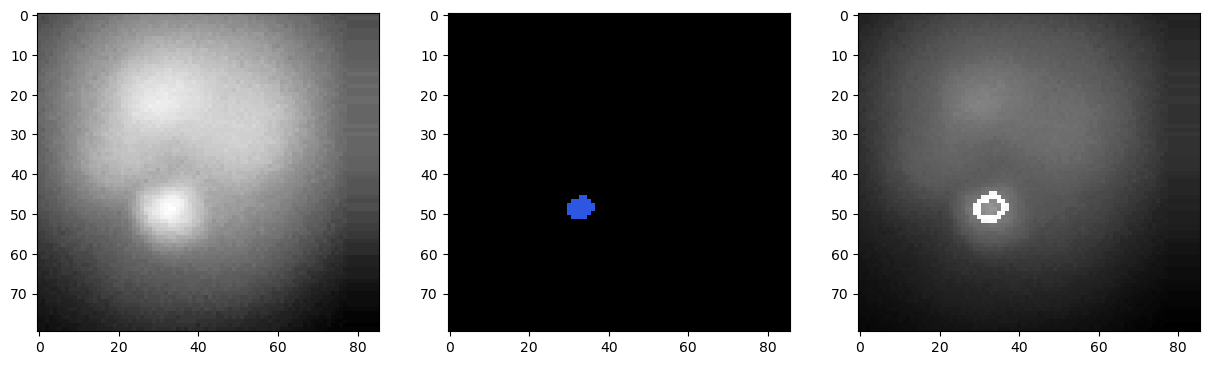

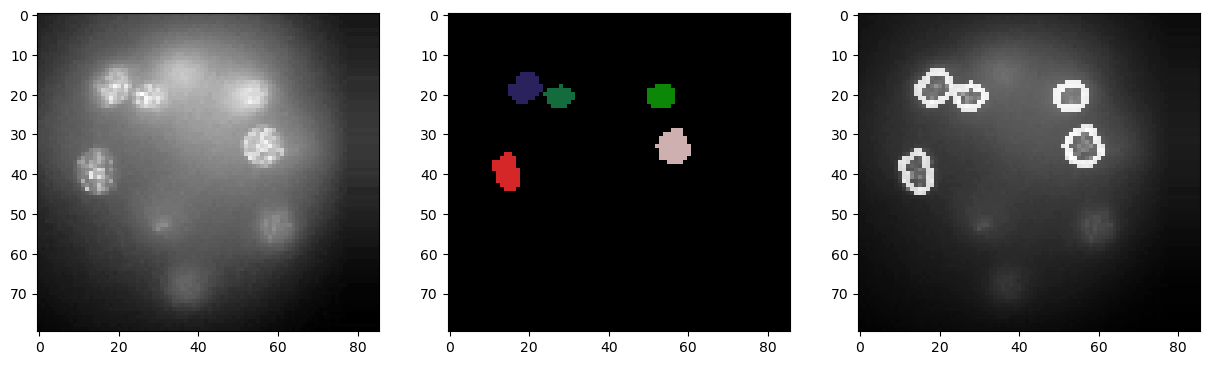

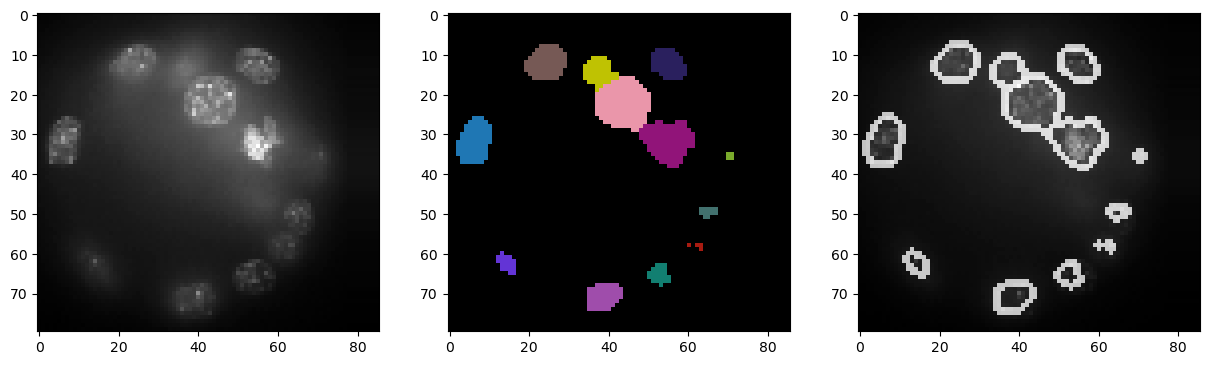

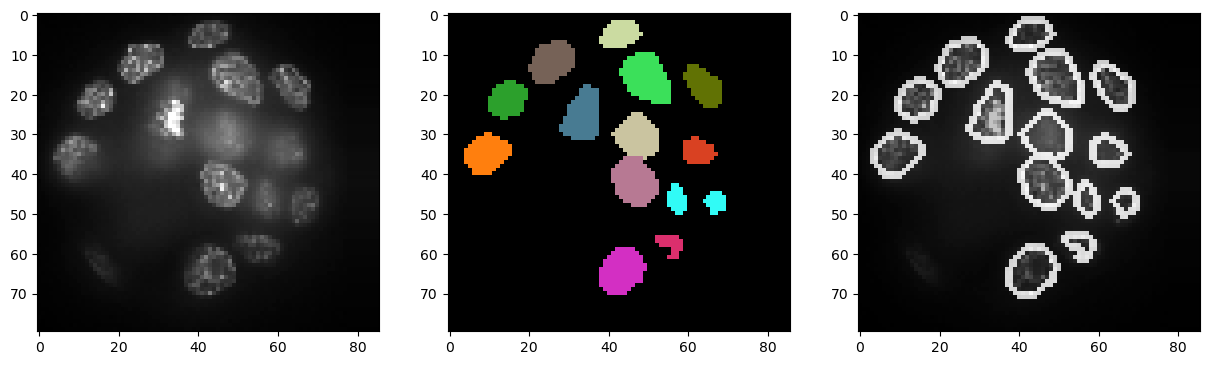

In [8]:
a_slice = cle.create([resampled.shape[1], resampled.shape[0]])
segmented_slice = cle.create([resampled.shape[1], resampled.shape[0]])

for z in range(0, resampled.shape[2], 20):
    label_outlines = None
    combined = None

    # get a single slice from the intensity image and the segmented label image
    cle.copy_slice(resampled, a_slice, z)
    cle.copy_slice(segmented, segmented_slice, z)

    # determine outlines around labeled objects
    label_outlines = cle.detect_label_edges(segmented_slice, label_outlines)

    # combine both images
    outline_intensity_factor = cle.maximum_of_all_pixels(a_slice)
    combined = cle.add_images_weighted(a_slice, label_outlines, combined, 1.0, outline_intensity_factor)

    # visualisation
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(a_slice, plot=axs[0])
    cle.imshow(segmented_slice, plot=axs[1], labels=True)
    cle.imshow(combined, plot=axs[2])

In [9]:
# start napari
viewer = napari.Viewer()

# show images
viewer.add_image(cle.pull(resampled))
viewer.add_image(cle.pull(equalized_intensities_stack))
viewer.add_labels(cle.pull(segmented))

Assistant skips harvesting pyclesperanto as it's not installed.


<Labels layer 'Labels' at 0x2a7230ca0>

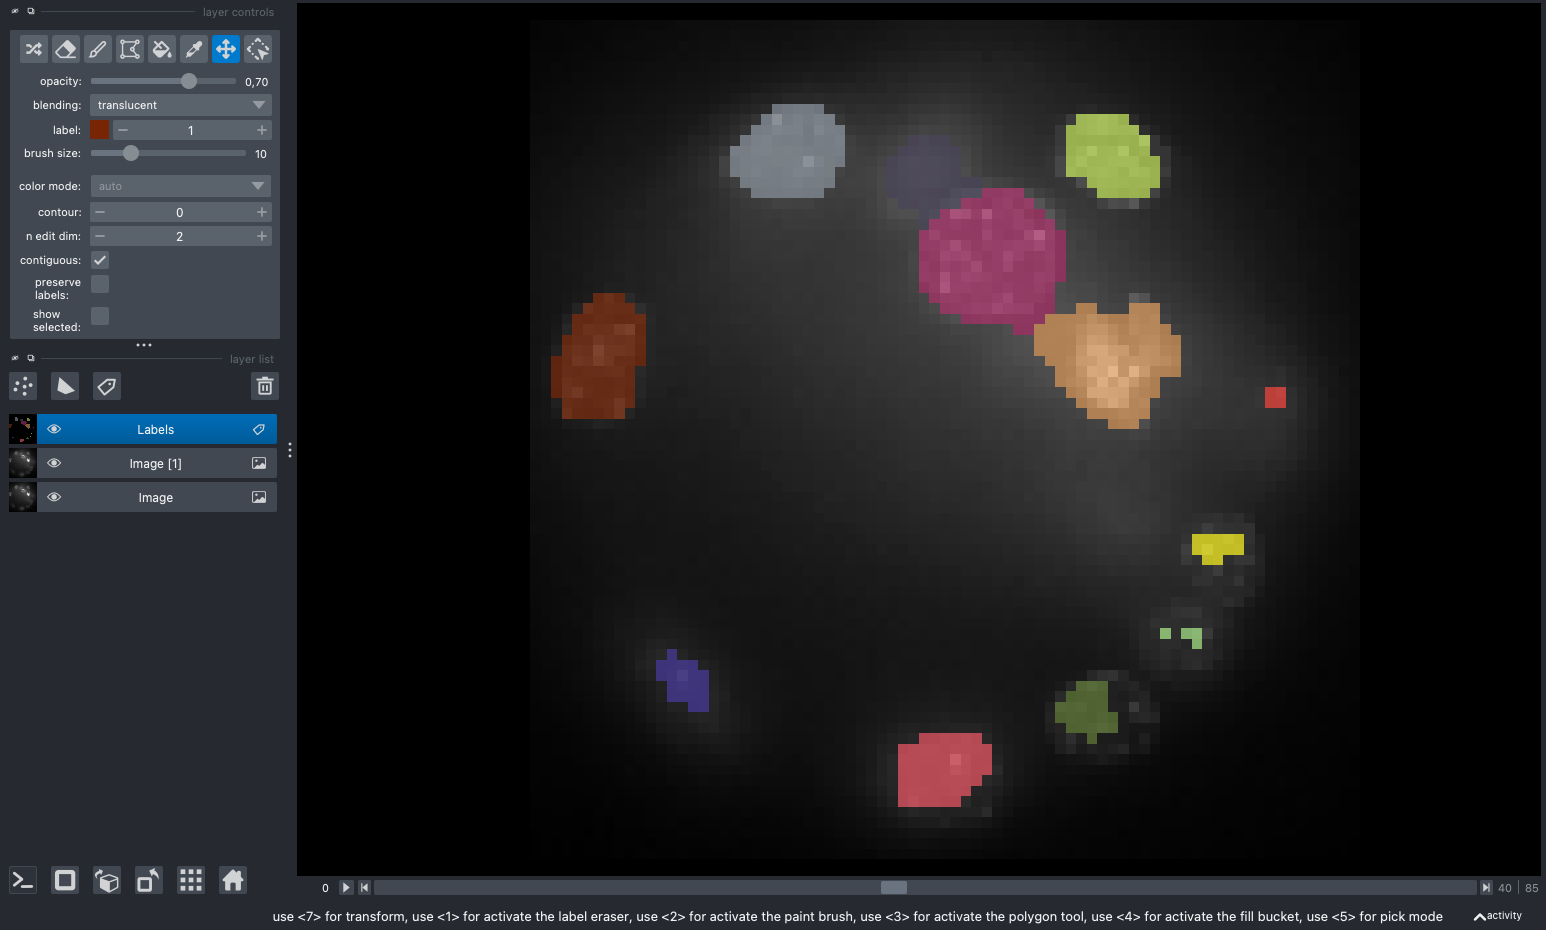

In [10]:
viewer.dims.current_step = (40, 0, 0)
nbscreenshot(viewer)

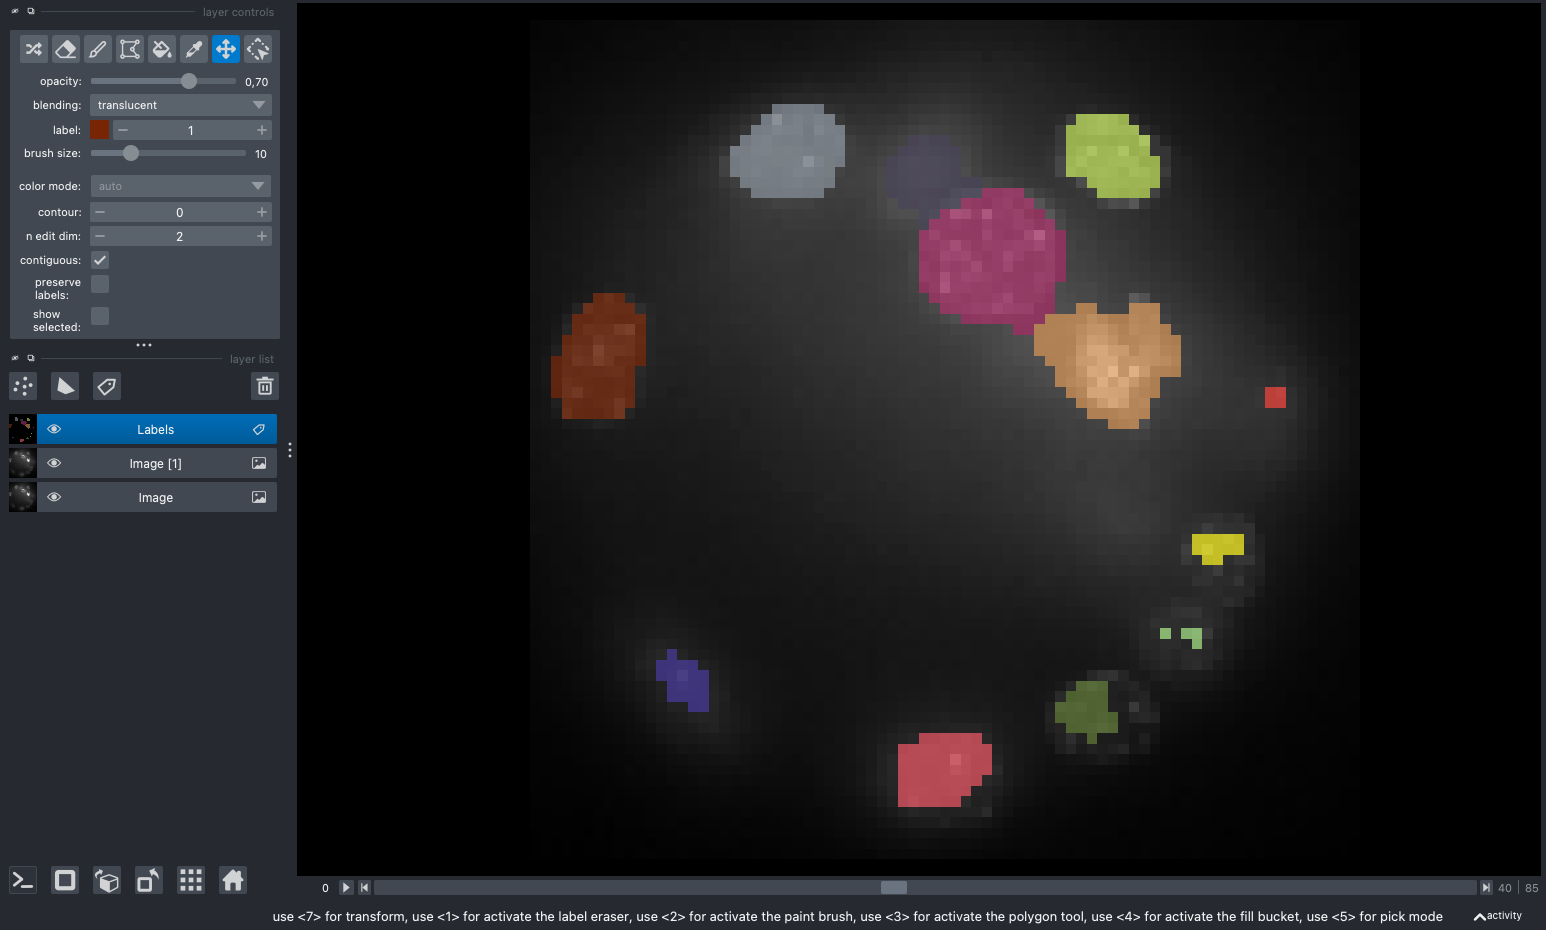

In [11]:
nbscreenshot(viewer)

In [ ]:
#####################################################
###
### test an example from 
### https://jni.github.io/i2k-skimage-napari/lectures/2_segmentation_and_regionprops.html#id1
###
#####################################################

In [12]:
import numpy as np
from scipy import ndimage as ndi

import napari

from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

viewer = napari.Viewer()
image_layer = viewer.add_image(image)
labels_layer = viewer.add_labels(labels)
labels_as_image_layer = viewer.add_image(
    labels, name='labels as image'
)

In [ ]:
import tifffile

nuclei = tifffile.imread('../images/cells.tif')
membranes = tifffile.imread('../images/cells_membrane.tif')

print("shape: {}".format(nuclei.shape))
print("dtype: {}".format(nuclei.dtype))
print("range: ({}, {})".format(np.min(nuclei), np.max(nuclei)))